In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)

species_of_interest = ["@H2SIO", "H", "H2", "O", "C", "N", "CL", "E-", "CO", "MG", "#C", "H2O", "SI", 'SURFACE', 'BULK', 'C+']
physical_params = ['density', 'gasTemp', 'av', 'radField']

In [2]:
x = os.listdir('data/chemistry_tracers_csv/')
y = []
for file in x:
    if file == "M600_1_1_Tracer_10_.csv":
        continue
    y.append(int(file.replace('M600_1_1_Tracer_', '').replace('.csv', '')))

indices = list(sorted(set(y)))

In [3]:
results = {}
most_stiff = []

for ind in indices:
    try:
        df = pd.read_csv(f"data/chemistry_tracers_csv/M600_1_1_Tracer_{ind}.csv")
        stiffness = {
            col: np.log10(df[col][df[col] > 0]).clip(lower=-20).diff().abs().mean()
            for col in df.select_dtypes(include=[np.number]).columns
        }
        results[ind] = stiffness

        # find stiffest column for this file
        col, val = max(stiffness.items(), key=lambda x: x[1] if x[1] is not None else -np.inf)
        most_stiff.append((ind, col, val))

    except Exception as e:
        print(f"Error reading file {ind}: {e}")

# sort by most stiff overall
most_stiff.sort(key=lambda x: x[2], reverse=True)

print("\nMost stiff columns across files:")
for ind, col, val in most_stiff:
    print(f"File {ind}, Column {col}: {val}")


Most stiff columns across files:
File 5170, Column BULK: 0.6243285775950064
File 16451, Column BULK: 0.5419502368989172
File 18202, Column BULK: 0.4734044370856047
File 23127, Column BULK: 0.47096735487978053
File 9060, Column BULK: 0.4443177210339023
File 24564, Column BULK: 0.40119779707614384
File 19348, Column BULK: 0.382722407631414
File 6161, Column BULK: 0.37424877229192394
File 26506, Column BULK: 0.36315744156839924
File 15908, Column BULK: 0.32626326374702047
File 23410, Column BULK: 0.3124671382152531
File 2111, Column BULK: 0.3056109696762637
File 17298, Column C2H3: 0.2969724544876665
File 8824, Column BULK: 0.2828441720947967
File 27562, Column BULK: 0.27773085315485746
File 10151, Column BULK: 0.27137501593591684
File 11812, Column BULK: 0.2618243238710981
File 19460, Column #CH4: 0.25800941962776724
File 8231, Column BULK: 0.2578543041007447
File 31451, Column C2H3: 0.2564267197390482
File 29316, Column #C2H4: 0.2515145032015242
File 5712, Column #H2CO: 0.2513688694366

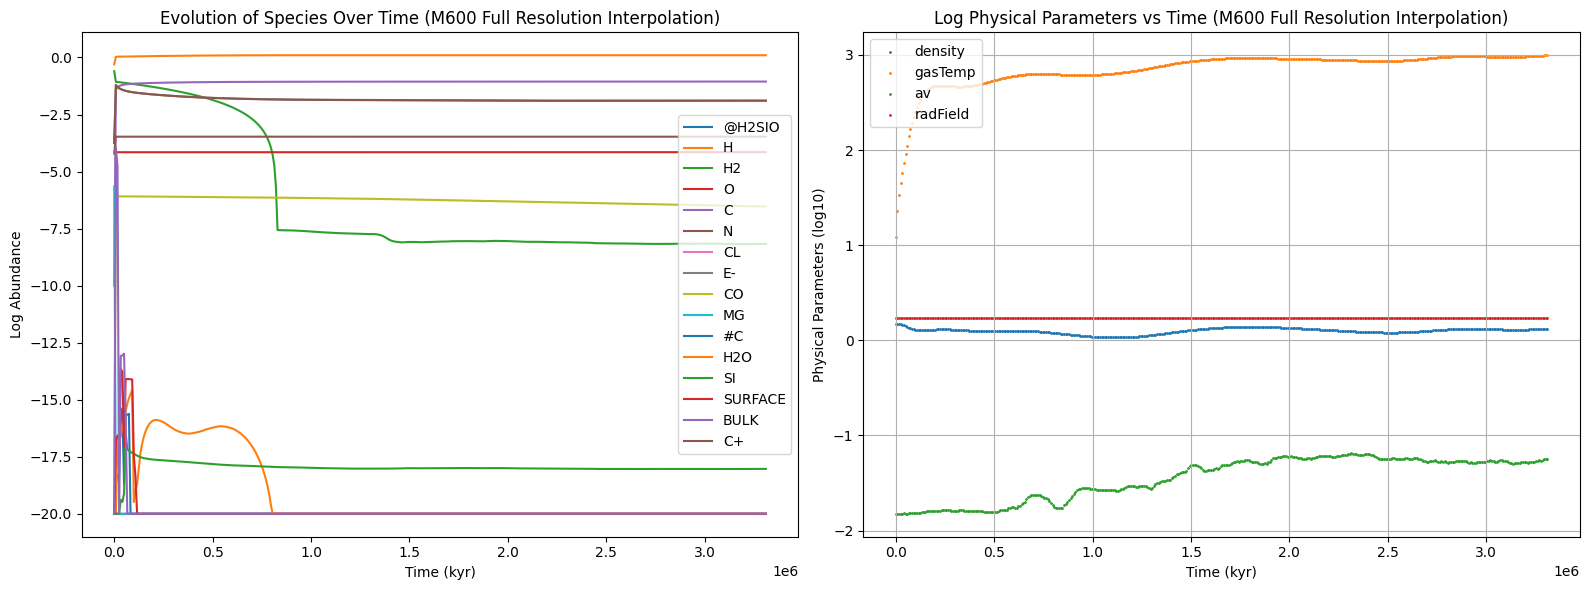

In [7]:
df = pd.read_csv('data/chemistry_tracers_csv/M600_1_1_Tracer_35226.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for species in species_of_interest:
    if species in df.columns:
        log_abundance = np.log10(df[species].replace(0, np.nan))
        log_abundance = np.maximum(log_abundance, -20)
        ax1.plot(df['time'], log_abundance, label=species)

ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600 Full Resolution Interpolation)')
ax1.legend()

for param in physical_params:
    if param in df.columns:
        y = pd.to_numeric(np.log10(df[param]), errors='coerce')
        ax2.scatter(df['time'], y, label=param, s=1)

ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameters (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600 Full Resolution Interpolation)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()